# Extracting color from VFX images
We want to test the LLMs capacity to extract the ability type from the video, and we want to be able to verify this. One idea here is that the colors and brightnesses for different elemental types are given in the League VFX design manual, therefore using OpenCV and some operations we may be able to quickly verify which is the most fitting class. 

In [3]:
import pathlib
import cv2
import numpy as np

frames_path = pathlib.Path("Data/Frames")

In [100]:
import imageio

FPS = 3

def get_frames(video_file):
    video_reader = imageio.get_reader(video_file, "ffmpeg")
    metadata = video_reader.get_meta_data()
    video_fps = metadata['fps']
    duration = metadata['duration']

    frame_interval = int(video_fps // FPS)
    frame_indices = [i for i in range(0, int(duration * video_fps), frame_interval)]

    frames = []
    for idx in frame_indices:
        try:
            frame = video_reader.get_data(idx)
            frames.append(frame)
        except IndexError:
            break

    video_reader.close()
    return frames

In [4]:
import json
from PIL import ImageColor

HUE_PALETTES = json.load(open("Schemas/spell_types.json"))['vfx_characteristics']['elemental_type']
HUE_PALETTES = {k: v['color_palette'].split(",") for k, v in HUE_PALETTES.items()}
for palette in HUE_PALETTES.values():
    for i, color in enumerate(palette):
        rgb = ImageColor.getrgb(color.strip())
        rgb_array = np.array([[rgb]], dtype=np.uint8)
        hsv = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HSV)
        palette[i] = {'H': hsv[0, 0, 0].item(), 'RGB': rgb}

LUMINANCE = ["#e8e8e8", "#b1b1b1", "#545454"]
for i, luminance in enumerate(LUMINANCE):
    LUMINANCE[i] = ImageColor.getcolor(luminance, "L")

LUMINANCE, HUE_PALETTES

([232, 177, 84],
 {'hextech': [{'H': 141, 'RGB': (165, 32, 224)},
   {'H': 129, 'RGB': (218, 202, 255)},
   {'H': 149, 'RGB': (254, 230, 255)},
   {'H': 90, 'RGB': (223, 255, 255)},
   {'H': 110, 'RGB': (8, 79, 229)},
   {'H': 90, 'RGB': (122, 255, 255)}],
  'wind': [{'H': 88, 'RGB': (157, 183, 181)},
   {'H': 88, 'RGB': (78, 201, 192)},
   {'H': 99, 'RGB': (50, 131, 164)},
   {'H': 87, 'RGB': (192, 254, 248)},
   {'H': 33, 'RGB': (44, 45, 33)}],
  'water': [{'H': 103, 'RGB': (43, 100, 145)},
   {'H': 106, 'RGB': (29, 73, 124)},
   {'H': 103, 'RGB': (14, 41, 62)},
   {'H': 103, 'RGB': (82, 176, 247)},
   {'H': 93, 'RGB': (195, 250, 255)}],
  'frost': [{'H': 94, 'RGB': (105, 217, 235)},
   {'H': 110, 'RGB': (32, 99, 237)},
   {'H': 119, 'RGB': (0, 8, 177)},
   {'H': 90, 'RGB': (161, 254, 254)}],
  'gun_powder': [{'H': 23, 'RGB': (248, 198, 23)},
   {'H': 5, 'RGB': (187, 47, 18)},
   {'H': 12, 'RGB': (105, 64, 35)},
   {'H': 30, 'RGB': (238, 239, 11)}],
  'arcane': [{'H': 111, 'RGB': (53

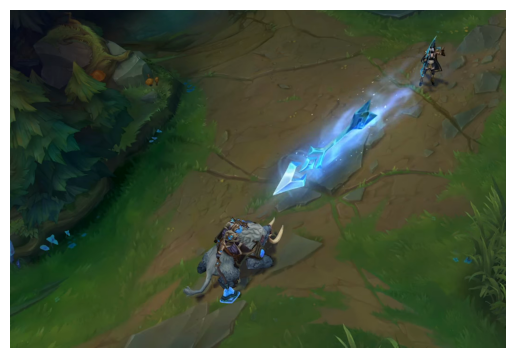

In [12]:
from matplotlib import pyplot as plt

image = cv2.imread(frames_path / "Ashe_R_0005.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb); plt.axis('off'); plt.savefig('original.png', transparent=True, format='png', dpi=600)

In [7]:
# grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# brightest_vfx_mask = grayscale > LUMINANCE[0]
# medium_brightness_vfx_mask = grayscale > LUMINANCE[1]
# low_brightness_vfx_mask = grayscale > LUMINANCE[2]
# 
# vfx_masked_bright = grayscale.copy()
# vfx_masked_medium = grayscale.copy()
# vfx_masked_low = grayscale.copy()
# 
# vfx_masked_bright[~brightest_vfx_mask] = 0
# vfx_masked_medium[~medium_brightness_vfx_mask] = 0
# vfx_masked_low[~low_brightness_vfx_mask] = 0

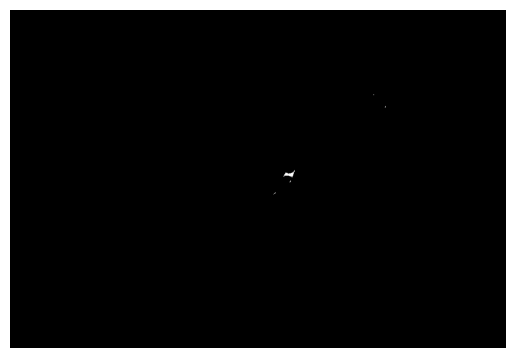

In [9]:
# plt.imshow(vfx_masked_low, cmap="gray"); plt.axis('off'); plt.savefig('vfx_mask_low_bright.png', transparent=True, format='png', dpi=600)
# plt.imshow(vfx_masked_medium, cmap="gray"); plt.axis('off'); plt.savefig('vfx_mask_medium_bright.png', transparent=True, format='png', dpi=600)
# plt.imshow(vfx_masked_bright, cmap="gray"); plt.axis('off'); plt.savefig('vfx_mask_highest_bright.png', transparent=True, format='png', dpi=600)

In [333]:
# percent_hue_match = {}
# rgb_leniency = 40
# 
# grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# brightness_mask = grayscale > LUMINANCE[1]
# 
# for name, palette in HUE_PALETTES.items():
#     color_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=bool)
#     for color in palette:
#         rgb = color['RGB']
#         mod_diff = abs(rgb - image_rgb)
#         color_mask |= np.all(mod_diff <= rgb_leniency, axis=-1)
#     
#     vfx_masked = image_rgb.copy()
#     vfx_masked[~color_mask] = 0
#     vfx_masked[~brightness_mask] = 0
#     percent_hue_match[name] = np.count_nonzero(vfx_masked) / vfx_masked.size * 100
#     plt.imshow(vfx_masked); plt.title(name); plt.axis('off'); plt.show()
# percent_hue_match

In [169]:
def get_percent_hue_match_by_spell_type(image, leniency=20):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image_h = image_hsv[:, :, 0].astype(np.int16)
    percent_hue_match = {}
    masked_images = {}
    
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness_mask = grayscale > LUMINANCE[2]
    
    for name, palette in HUE_PALETTES.items():
        color_mask = np.zeros_like(image_h, dtype=bool)
        for color in palette:
            hue = color['H']
            # Because of circular wrap around hue 179 is both very close to h = 0, h = 178
            mod_diff = np.minimum(abs(hue - image_h), 179 - abs(hue - image_h))
            color_mask |= mod_diff <= leniency
        
        vfx_masked = image.copy()
        vfx_masked[~color_mask] = 0
        vfx_masked[~brightness_mask] = 0
        masked_images[name] = vfx_masked
        percent_hue_match[name] = np.count_nonzero(vfx_masked) / vfx_masked.size * 100
        
    return percent_hue_match, masked_images

In [173]:
import os
import random

video_selection = []

while len(video_selection) < 15:
    all_champs = [dir for dir in os.listdir("Data/Videos") if not dir.startswith(".")]
    random_champ = random.choice(all_champs)
    
    champ_abilities = [file for file in os.listdir("Data/Videos/" + random_champ) if file.endswith(".webm")]
    random_champ_ability = random.choice(champ_abilities)

    matches = []
    for frame in get_frames(f"Data/Videos/{random_champ}/{random_champ_ability}"):
        percent_match, masked = get_percent_hue_match_by_spell_type(frame)
        spell_type = max(percent_match, key=percent_match.get)
        if percent_match[spell_type] > 3.0:
            matches.append((masked[spell_type], frame))
    if len(matches) > 0:
        video_selection.append(random.choice(matches)) # Select a random moment where the masking is good
        

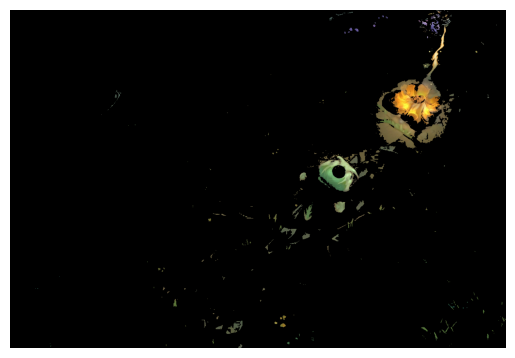

In [178]:
masked, image = video_selection[2]
plt.imshow(image); plt.axis('off'); plt.savefig('original.png', transparent=True, format='png', dpi=600)
plt.imshow(masked); plt.axis('off'); plt.savefig('masked.png', transparent=True, format='png', dpi=600)

In [179]:
import pickle

pickle.dump(video_selection, open("Data/GT/bb.pickle", "wb"))

In [125]:
image.shape

(720, 1056, 3)